In [67]:
import re
import csv
from io import StringIO
from bs4 import BeautifulSoup
import requests
import talib
import yfinance as yf
import numpy as np
import pandas  as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline


In [ ]:
#downloading the important data for

In [29]:
data = yf.download('BTC-USD', start="2016-03-17", end="2021-03-17")
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-03-16,416.888000,417.686005,415.911987,417.010986,417.010986,65185800
2016-03-17,417.889008,420.997009,417.889008,420.621002,420.621002,83528600
2016-03-18,420.546997,420.546997,406.136993,409.548004,409.548004,104940000
2016-03-19,409.265015,410.984009,407.230011,410.444000,410.444000,58423000
2016-03-20,410.401001,414.625000,410.401001,413.755005,413.755005,45947900


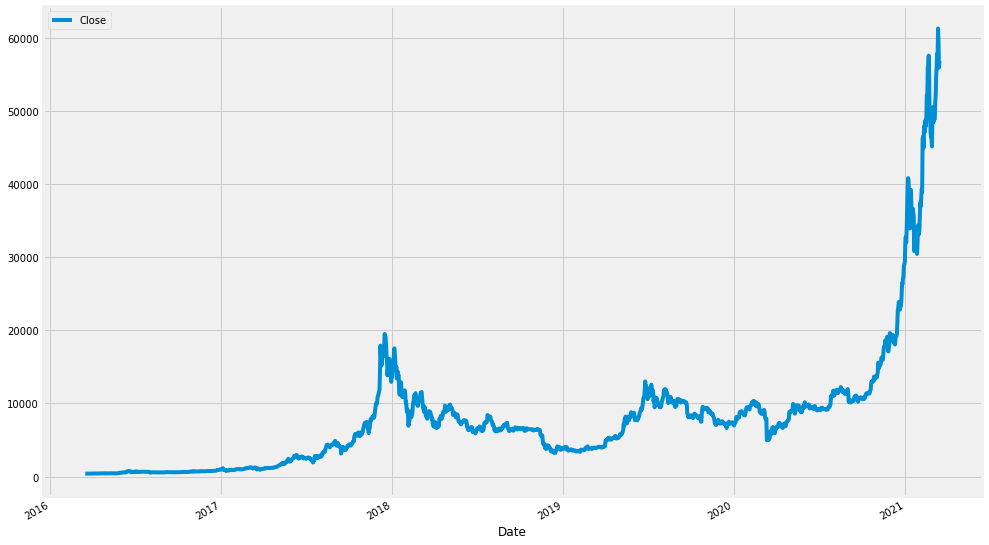

In [30]:
#visualization
plt.figure(figsize=(10,5))
data['Close'].plot(figsize=(15,10))
plt.legend()
plt.show()


In [ ]:
#Moving Average Convergence Divergence (MACD)
#Moving Average Convergence Divergence or MACD  is one of the simplest and effective trend-following momentum indicators.
#We can trigger the trading signal using MACD series and signal series.
#Strategy is when short term EMA crosses the long term EMA, this may indicate a buy signal(golden cross) 
# or when the short term moving average crosses below the long term moving average, it may be a good moment to sell.
#When the MACD line crosses above the signal line, then it is recommended to buy the underlying security.
#When the MACD line crosses below the signal line, then a signal to sell is triggered.

In [ ]:
#The formula for the Exponential Moving Average(EMA) is given below:

#EMA = (Closing price - EMA*(previous day)) x multiplier  +  EMA*(previous day)

# where Weightage multiplier = 2 / (moving average period +1)
#Pandas support in-built function to calculate exponential weighted average (ewm), we use it to calculate EMA

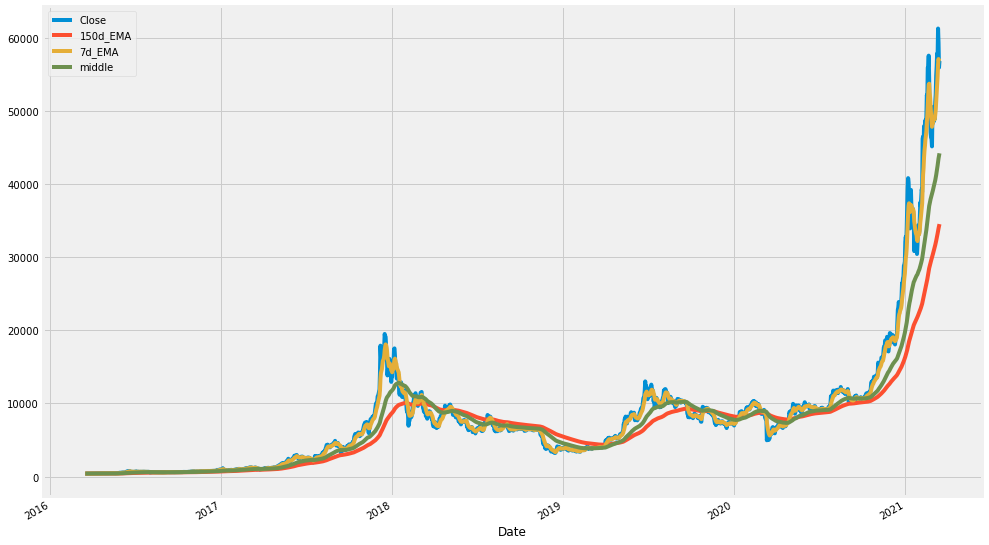

In [31]:
# Calculate exponential moving average
data['7d_EMA'] = data.Close.ewm(span=7, adjust=False).mean()
data['150d_EMA'] = data.Close.ewm(span=150, adjust=False).mean()
data['middle'] = data.Close.ewm(span=71, adjust=False).mean()
data[['Close','150d_EMA','7d_EMA','middle']].plot(figsize=(15,10))
plt.show()

In [32]:
data.head(5)

,Open,High,Low,Close,Adj Close,Volume,7d_EMA,150d_EMA,middle
Date,,,,,,,,,
2016-03-16,416.888000,417.686005,415.911987,417.010986,417.010986,65185800,417.010986,417.010986,417.010986
2016-03-17,417.889008,420.997009,417.889008,420.621002,420.621002,83528600,417.913490,417.058801,417.111265
2016-03-18,420.546997,420.546997,406.136993,409.548004,409.548004,104940000,415.822119,416.959320,416.901174
2016-03-19,409.265015,410.984009,407.230011,410.444000,410.444000,58423000,414.477589,416.873025,416.721808
2016-03-20,410.401001,414.625000,410.401001,413.755005,413.755005,45947900,414.296943,416.831726,416.639397


In [62]:
#creating a function when to buy/sell the asset
def buy_sell(data):
    sigPriceBuy = []
    sigPriceSell = []
    flag_long = False
    flag_short = False
    for i in range(0,len(data)):
        if data['middle'][i] > data['150d_EMA'][i] and data['7d_EMA'][i]  > data['middle'][i] and flag_long == False and flag_short == False:   # signaling us to buy
            sigPriceBuy.append(data['Adj Close'][i])
            sigPriceSell.append(np.nan)
            flag_short = True
        elif flag_short == True and data['7d_EMA'][i] > data['middle'][i]: 
            sigPriceSell.append(data['Adj Close'][i])
            sigPriceBuy.append(np.nan)
            flag_short = False
        elif data['middle'][i] < data['150d_EMA'][i] and data['7d_EMA'][i] < data['middle'][i] and flag_long == False and flag_short == False:   # signaling us to buy
            sigPriceBuy.append(data['Adj Close'][i])
            sigPriceSell.append(np.nan)
            flag_long = True
        elif flag_long == True and data['7d_EMA'][i] > data['middle'][i]:  # signalling us to sell the asset
             # set stop loss to 5%
            stop_loss = data['Adj Close'][i] - (data['Adj Close'][i] * 0.05)
            sigPriceSell.append(stop_loss)
            sigPriceBuy.append(np.nan)
            flag_long = False        
        else:
            sigPriceBuy.append(np.nan)
            sigPriceSell.append(np.nan)
    return (sigPriceBuy, sigPriceSell)       

In [63]:
buy_sell = buy_sell(data)
data['Buy_Signal_Price'] = buy_sell[0]
data['Sell_Signal_Price'] = buy_sell[1]

In [64]:
data.head()

,Open,High,Low,Close,Adj Close,Volume,7d_EMA,150d_EMA,middle,Buy_Signal_Price,Sell_Signal_Price
Date,,,,,,,,,,,
2016-03-16,416.888000,417.686005,415.911987,417.010986,417.010986,65185800,417.010986,417.010986,417.010986,NaN,NaN
2016-03-17,417.889008,420.997009,417.889008,420.621002,420.621002,83528600,417.913490,417.058801,417.111265,420.621002,NaN
2016-03-18,420.546997,420.546997,406.136993,409.548004,409.548004,104940000,415.822119,416.959320,416.901174,NaN,NaN
2016-03-19,409.265015,410.984009,407.230011,410.444000,410.444000,58423000,414.477589,416.873025,416.721808,NaN,NaN
2016-03-20,410.401001,414.625000,410.401001,413.755005,413.755005,45947900,414.296943,416.831726,416.639397,NaN,NaN


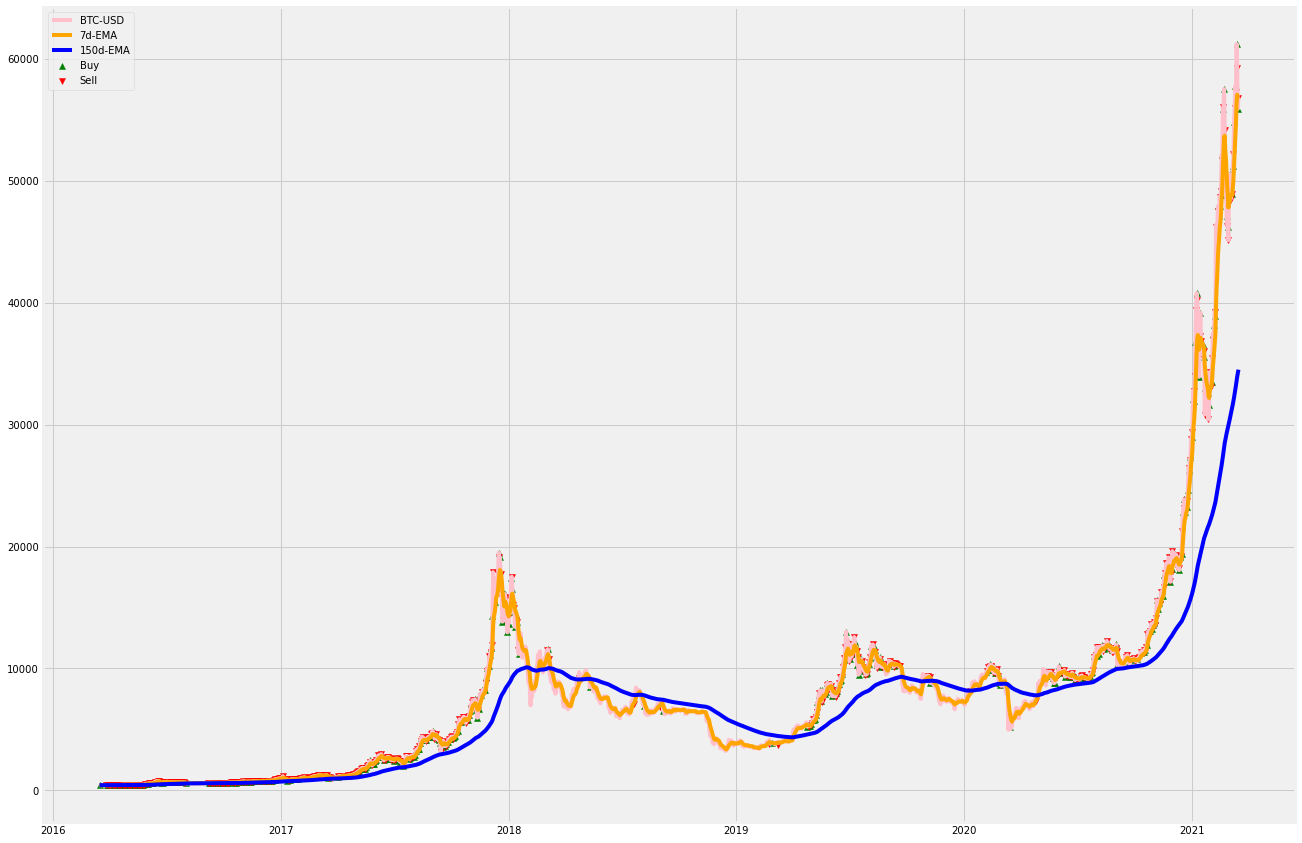

In [65]:
#visualize the data and strategy to buy and sell the stock
plt.figure(figsize=(20,15))
plt.grid(True)
plt.plot(data['Adj Close'], label = 'BTC-USD', color = 'pink')
plt.plot(data['7d_EMA'], label = '7d-EMA', color = 'orange')
plt.plot(data['150d_EMA'], label = '150d-EMA', color = 'blue')
plt.scatter(data.index, data['Buy_Signal_Price'], label = 'Buy', marker ='^', color = 'green', alpha = 1)
plt.scatter(data.index, data['Sell_Signal_Price'], label = 'Sell', marker ='v', color = 'red', alpha = 1)
plt.legend(loc= 'upper left')
plt.show()


In [73]:
#Now creating a simple trading signal i.e When the value of MACD series is greater than signal series then buy[REPRESENTED AS (1)],
#else sell[Represented as (-1)]. For checking our strategy and calculating the returns

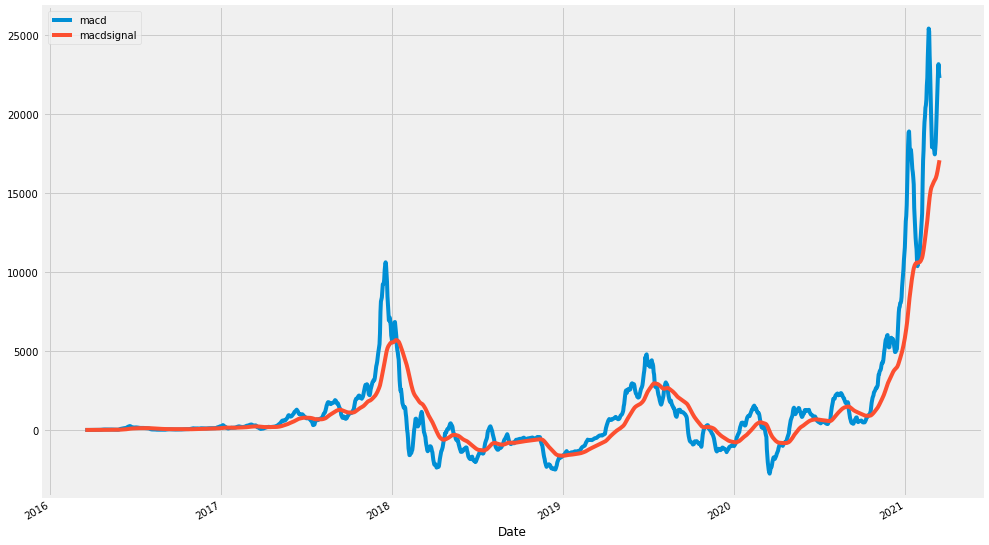

In [69]:
# Calculate MACD
data['macd'] = data['7d_EMA'] - data['150d_EMA'] 

# Calculate Signal
data['macdsignal'] = data.macd.ewm(span=71, adjust=False).mean()

# trading signal
data['trading_signal'] = np.where(data['macd'] > data['macdsignal'], 1, -1)
data[['macd','macdsignal']].plot(figsize=(15,10))
plt.show()

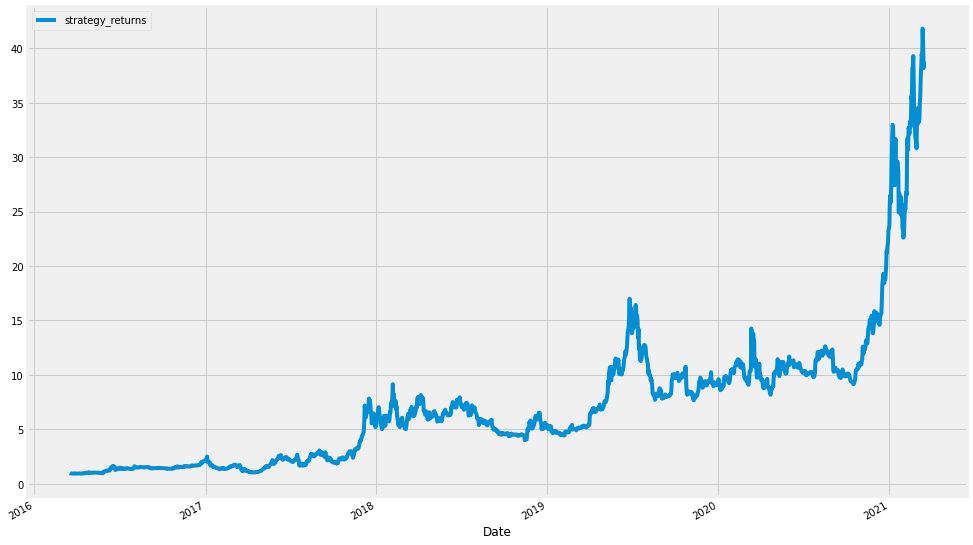

In [70]:
# Calculate Returns
data['returns'] = data.Close.pct_change()

# Calculate Strategy Returns
data['strategy_returns'] = data.returns * data.trading_signal.shift(1)

# Calculate Cumulative Returns
cumulative_strategy_returns = (data.strategy_returns + 1).cumprod()

# Plot Strategy Returns
cumulative_strategy_returns.plot(figsize=(15,10))
plt.legend()
plt.show()

In [71]:
# Total number of trading days
days = len(cumulative_strategy_returns)

# Calculate compounded annual growth rate
annual_returns = (cumulative_strategy_returns.iloc[-1]**(252/days) - 1)*100

'The CAGR is %.2f%%' % annual_returns

'The CAGR is 65.80%'

In [72]:
# Calculate the annualised volatility
annual_volatility = data.strategy_returns.std() * np.sqrt(252) * 100

'The annualised volatility is %.2f%%' % annual_volatility

'The annualised volatility is 63.72%'